 # Glioma Classification using TCGA Data with ANOVA-based Feature Selection

In [15]:
!conda env create -f environment.yml
!pip install ipykernel
!python -m ipykernel install --user --name JupyterLab --display-name "Python (JupyterLab)"


EnvironmentFileNotFound: '/home/kbanerj1/TCGA_ML/environment.yml' file not found

Installed kernelspec JupyterLab in /home/kbanerj1/.local/share/jupyter/kernels/jupyterlab


In [16]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read the datasets

In [17]:
os.chdir("/home/kbanerj1/TCGA_ML")
# Verify the current directory
print("Current Directory:", os.getcwd())

Current Directory: /home/kbanerj1/TCGA_ML


In [18]:
# load the dataset
extraction_dir = "./processed"
data_path = os.path.join(extraction_dir, 'data.csv')
labels_path = os.path.join(extraction_dir, 'glioma_labels.csv')
data_df = pd.read_csv(data_path)
labels_df = pd.read_csv(labels_path)

print("Gene Expression Data Shape:\n", data_df.shape)
print("\nLabels Head:\n", labels_df.shape)

Gene Expression Data Shape:
 (575, 56941)

Labels Head:
 (575, 2)


In [19]:
data_df.head(5)

,Sample ID,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,AC010980.1,AC007511.1,AC004233.4,AC092910.4,AC073611.1,AC078856.1,AC008763.4,AL592295.6,AL391628.1,AP006621.6
0,C3L-03748-04,23.1111,0.6403,54.5838,8.5518,5.0768,15.8079,19.5741,34.2537,6.2192,...,0.1593,0.2304,0.1857,22.5009,0.8291,58.6499,0.0,10.0862,0.0772,1.0849
1,HCM-BROD-0106-C71-02A,32.7368,0.0000,40.9448,6.5248,5.5556,10.8877,10.9730,30.3679,21.5079,...,0.1704,0.0000,0.0000,9.0727,0.2456,8.2865,0.0,10.2641,0.0485,1.0184
2,HCM-BROD-0106-C71-85A,6.8030,0.0176,25.6094,1.2793,1.0181,0.8602,0.1758,6.7745,4.3945,...,0.0000,0.0000,0.0715,2.1646,0.4695,1.7033,0.0,3.9099,0.0810,0.5875
3,HCM-BROD-0103-C71-85B,12.3865,0.3824,79.7468,6.8692,10.3986,0.3708,0.0550,18.8208,4.6786,...,0.5284,0.2140,0.0000,6.2706,2.6297,17.4756,0.0,9.9248,0.1043,1.6796
4,HCM-BROD-0210-C71-02A,17.9934,0.4160,40.4237,7.5759,6.0208,12.4017,7.8958,33.3575,21.0514,...,0.2070,0.0000,0.0000,7.8721,0.3978,15.4861,0.0,14.1672,0.1178,0.9278


In [20]:
labels_df.head(5)

,Sample ID,label
0,C3L-03748-04,Glioblastoma
1,HCM-BROD-0106-C71-02A,Glioblastoma
2,HCM-BROD-0106-C71-85A,Glioblastoma
3,HCM-BROD-0103-C71-85B,Glioblastoma
4,HCM-BROD-0210-C71-02A,Glioblastoma


## Data Pre-processing

In [21]:
# checking for missing values in both data and labels
missing_values_data = data_df.isnull().sum().sum()
missing_values_labels = labels_df.isnull().sum().sum()
print(f"\nMissing values in data: {missing_values_data}")
print(f"Missing values in labels: {missing_values_labels}")


Missing values in data: 0
Missing values in labels: 0


In [22]:
data_df= data_df.rename(columns={"Sample ID": "sample"})
labels_df = labels_df.rename(columns={"Sample ID": "sample", "label":"cancer_type"})

# set 'sample' as the index
data_df.set_index('sample', inplace=True)
data_df.columns

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'AC010980.1', 'AC007511.1', 'AC004233.4', 'AC092910.4', 'AC073611.1',
       'AC078856.1', 'AC008763.4', 'AL592295.6', 'AL391628.1', 'AP006621.6'],
      dtype='object', length=56940)

In [23]:
labels_df.columns

Index(['sample', 'cancer_type'], dtype='object')

In [24]:
# Pre-filter: Remove genes with no variance across samples
data_df = data_df.loc[:, data_df.var() != 0]
data_df.shape

(575, 56873)

In [25]:
# check labels distribution
# Checking the balance of classes in the target variable - pretty balanced overall
class_distribution = labels_df['cancer_type'].value_counts()
class_distribution

cancer_type
Glioblastoma         209
Oligodendroglioma    184
Astrocytoma          182
Name: count, dtype: int64

### Normalization and Transposition

In [26]:
# transpose the data for feature selection
data_df_transposed = data_df.T  
data_df_transposed.shape

(56873, 575)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_df.iloc[:, 1:])  
data_df_normalized = pd.DataFrame(normalized_data, index=data_df.index, columns=data_df.columns[1:])

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(labels_df['cancer_type'])  # Encoded labels for the samples
le.classes_, le.transform(le.classes_)

(array(['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma'], dtype=object),
 array([0, 1, 2]))

### Visualization on Un-selected Features
#### PCA

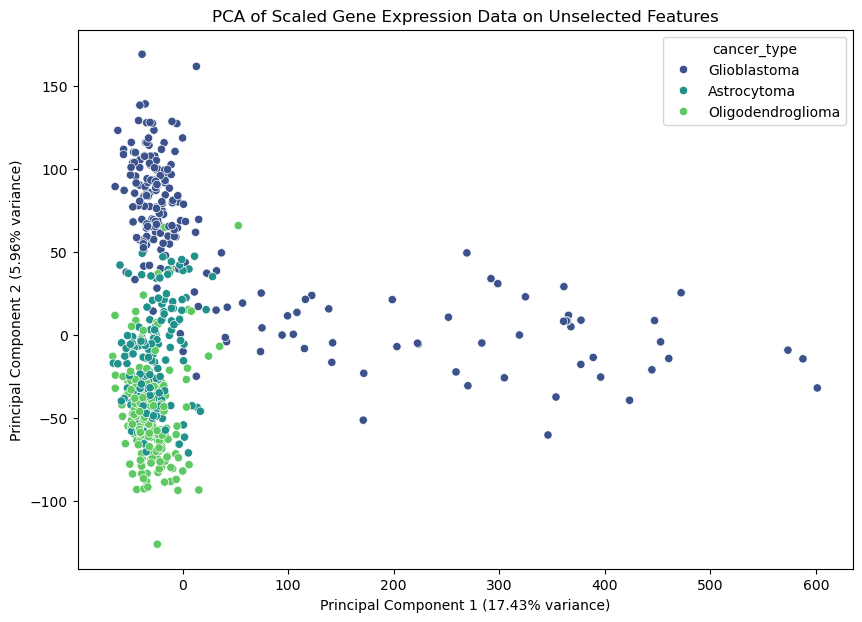

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca_unselected = PCA(n_components=2)
X_pca_unselected = pca_unselected.fit_transform(data_df_normalized)

explained_variance = pca_unselected.explained_variance_ratio_
explained_var_pc1 = explained_variance[0] * 100  # Percentage
explained_var_pc2 = explained_variance[1] * 100  # Percentage

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_unselected[:, 0], y=X_pca_unselected[:, 1], hue=labels_df['cancer_type'], palette="viridis")
plt.title('PCA of Scaled Gene Expression Data on Unselected Features')
plt.xlabel(f'Principal Component 1 ({explained_var_pc1:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_var_pc2:.2f}% variance)')
plt.show()

#### UMAP

/home/kbanerj1/.conda/envs/JupyterLab/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kbanerj1/.conda/envs/JupyterLab/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


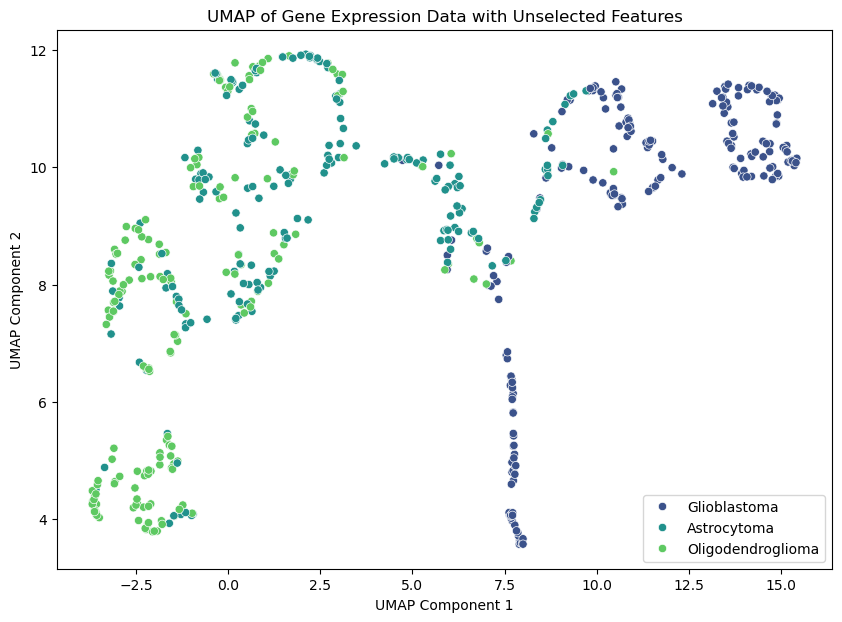

In [29]:
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_pca_unselected) 

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_df['cancer_type'], palette="viridis")
plt.title('UMAP of Gene Expression Data with Unselected Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='best')
plt.show()

## Feature Selection

### Selection across all classes 

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

def kruskal_feature_selection_top_k(X, y, k=100, alpha=0.05, method='fdr_bh'):
    """
    Perform Kruskal-Wallis H Test for each feature, apply FDR correction,
    and select top k features with the lowest corrected p-values among significant features.
    """
    # Transpose X so that genes are rows and samples are columns
    X = X.T  # Now genes are rows and samples are columns
    
    p_values = []
    unique_classes = np.unique(y)
    groups = {cls: X.loc[:, y == cls] for cls in unique_classes}  # group columns (samples) by class labels

    for feature in X.index:  # Iterate over genes (now rows)
        samples = [groups[cls].loc[feature].values for cls in unique_classes]
        stat, p = kruskal(*samples)
        p_values.append(p)

    p_values_df = pd.DataFrame({
        'Feature': X.index,
        'p-value': p_values
    })

    p_values_sorted = p_values_df.sort_values('p-value').reset_index(drop=True)

    reject, pvals_corrected, _, _ = multipletests(p_values_sorted['p-value'], alpha=alpha, method=method)
    p_values_sorted['p-value_corrected'] = pvals_corrected
    p_values_sorted['Significant'] = reject

    significant_features_df = p_values_sorted[p_values_sorted['Significant']].copy()
    significant_features_df = significant_features_df.reset_index(drop=True)

    num_significant = significant_features_df.shape[0]
    print(f"Number of significant features after FDR correction (alpha={alpha}): {num_significant}")

    if num_significant == 0:
        print("No features are significant after multiple testing correction.")
        selected_features_top_k = []
    else:
        # Select top k features from significant features
        k = min(k, num_significant)  # Adjust k if fewer significant features
        selected_features_top_k = significant_features_df['Feature'].iloc[:k].tolist()

    return selected_features_top_k, significant_features_df, p_values_sorted

In [31]:
# Perform feature selection - global
top_k_features, significant_features_df, p_values_sorted_df = kruskal_feature_selection_top_k(data_df_normalized, y, k=100, alpha=0.01)

Number of significant features after FDR correction (alpha=0.01): 40802


### Selection exclusively between Oligodendroglioma (2) and Astrocytoma (1) samples

In [36]:
labels_df1 = labels_df.copy()
labels_df1 = labels_df1.set_index('sample')

# ensure that the indices match
if labels_df1.index.equals(data_df_normalized.index):
    print("Indices match!")
else:
    print("Indices do not match.")
    
# filter for Oligodendroglioma (2) and Astrocytoma (1) samples
astro_oligo_df = labels_df1[labels_df1['cancer_type'].isin(['Oligodendroglioma', 'Astrocytoma'])]
astro_oligo_X = data_df_normalized.loc[astro_oligo_df.index]  
astro_oligo_y = astro_oligo_df['cancer_type'] 
print("Shape of astro_oligo_X:", astro_oligo_X.shape)
print("Shape of astro_oligo_y:", astro_oligo_y.shape)

Indices match!
Shape of astro_oligo_X: (366, 56872)
Shape of astro_oligo_y: (366,)


In [40]:
# Pre-filter: Remove genes with no variance across Oligodendroglioma and Astrocytoma samples
astro_oligo_X_filtered = astro_oligo_X.loc[:, astro_oligo_X.var() != 0]
astro_oligo_X_filtered.shape

(366, 56714)

There was an issue where the kruskal test wasn't able to run since the gene expression for some genes was the same, work around was to just find them separately and drop them. 

In [43]:
oligo_data = astro_oligo_X_filtered[astro_oligo_y == 'Oligodendroglioma']
astro_data = astro_oligo_X_filtered[astro_oligo_y == 'Astrocytoma']

# check genes where all values are identical within each class
oligo_constant_genes = oligo_data.loc[:, oligo_data.nunique() == 1].columns
astro_constant_genes = astro_data.loc[:, astro_data.nunique() == 1].columns

# Find genes that are constant in both classes
constant_genes_in_both_classes = oligo_constant_genes.intersection(astro_constant_genes)

print(f"Genes with identical values in both classes: {len(constant_genes_in_both_classes)}")
# drop from dataset
astro_oligo_X_filtered = astro_oligo_X_filtered.drop(columns=constant_genes_in_both_classes)

Genes with identical values in both classes: 453


In [44]:
top_k_features_oligo_astro, significant_features_df, p_values_sorted_df = kruskal_feature_selection_top_k(
    astro_oligo_X_filtered, astro_oligo_y, k=100, alpha=0.01)

print(f"Top {len(top_k_features_oligo_astro)} selected features:")
print(top_k_features_oligo_astro)

Number of significant features after FDR correction (alpha=0.01): 14083
Top 100 selected features:
['ASAP3', 'RUNDC3A-AS1', 'TRIM67', 'AL592078.2', 'CHGB', 'AL135999.3', 'INSM2', 'TRAPPC3', 'FAM155A', 'KCNK3', 'KRT8P30', 'UNC79', 'HMGCL', 'DEFB131E', 'LRRTM4', 'ABCC8', 'HDAC1', 'AK2', 'INA', 'DNAI4', 'XKR7', 'AC097468.2', 'ATCAY', 'RHOC', 'KCNJ11', 'SRRM3', 'NFIA', 'SCP2', 'CACNG2', 'MARCHF4', 'CNN3', 'DNALI1', 'LETMD1', 'GABRB3', 'LINC01206', 'AC107918.4', 'USF2', 'BLACAT1', 'AC004687.3', 'ZNF691', 'L1CAM', 'AL031658.2', 'CAPZB', 'ACTL6B', 'ZDHHC22', 'VIM', 'OMA1', 'NECAP2', 'MMP24', 'TNNT1', 'MMEL1', 'LCA10', 'WLS', 'AL133163.3', 'G6PC2', 'DOCK7', 'AC093802.1', 'CRTAC1', 'ITGB4', 'TAS1R1', 'LEKR1', 'AC026369.1', 'NFIA-AS2', 'TGIF1', 'LRRC20', 'AC022239.1', 'SRSF4', 'SCRT1', 'GPRIN1', 'BCL2L12', 'SMIM18', 'PINK1-AS', 'KCNIP2', 'SEZ6L2', 'GPBP1L1', 'PDZD4', 'PCBP3', 'PRAM1', 'NFATC1', 'FNBP1L', 'RASAL3', 'CDHR1', 'IRF3', 'CASP1', 'IGKV1D-8', 'RGR', 'STK40', 'MCF2', 'GABRA3', 'LINC02732

### Checking overlap of features 

In [48]:
# find the intersection of global and local top features
intersected_features = list(set(top_k_features) & set(top_k_features_oligo_astro))
print(f"Number of intersected features: {len(intersected_features)}")

Number of intersected features: 0


No common features so doing a union of them.

### Create final feature list

In [51]:
selected_features = list(set(top_k_features) | set(top_k_features_oligo_astro))
X_selected = data_df_normalized.loc[:, selected_features]
print(f"Shape of X_selected_intersected: {X_selected.shape}")
X_selected.head()

Shape of X_selected_intersected: (575, 200)


,GAPDHP60,AC006122.1,NFIA,GAPDHP38,RPS10P16,AL135999.3,KCNIP2,RPL7P26,INSM2,ATP5MDP1,...,PGK1P1,AC098591.3,FTH1P1,AC009362.1,G6PC2,AC022239.1,H2BS1,HMGCL,AC026111.1,TAS1R1
sample,,,,,,,,,,,,,,,,,,,,,
C3L-03748-04,1.323697,1.423711,0.805010,0.178921,0.984440,-0.478150,-0.556340,0.582161,-0.378770,-0.071974,...,0.477089,2.746697,3.848035,0.478069,-0.154021,-0.232546,-0.523164,-0.006882,4.145240,0.742883
HCM-BROD-0106-C71-02A,-0.191760,-0.019012,1.835303,-0.507487,0.081272,-0.763065,-0.611962,0.463890,-0.443245,0.311406,...,-0.153660,0.104147,-0.073236,0.396790,-0.220368,-0.238173,0.089604,-0.767487,0.747934,-0.295219
HCM-BROD-0106-C71-85A,-0.609566,0.334656,-0.944132,-0.525360,-0.589377,-0.763065,-0.634497,0.329107,-0.438271,-0.545079,...,-0.574356,0.502164,-0.337993,-0.483805,-0.257645,-0.227330,-0.386775,-1.293946,-0.145298,0.289595
HCM-BROD-0103-C71-85B,1.001867,15.396152,0.388092,0.204178,2.144051,-0.763065,-0.329066,3.554356,-0.499162,-0.105592,...,-0.251466,1.466041,3.691740,-0.357233,-0.196023,-0.238173,0.135721,-0.737786,2.944137,0.756821
HCM-BROD-0210-C71-02A,-0.108556,0.872994,1.662937,-0.287041,0.584764,-0.663409,-0.543301,-0.103791,-0.382567,0.779070,...,0.136038,0.694483,0.914188,1.134146,-0.222606,-0.206640,-0.026915,-0.313030,0.989006,-0.111572


### Visualization on Selected Features

#### PCA

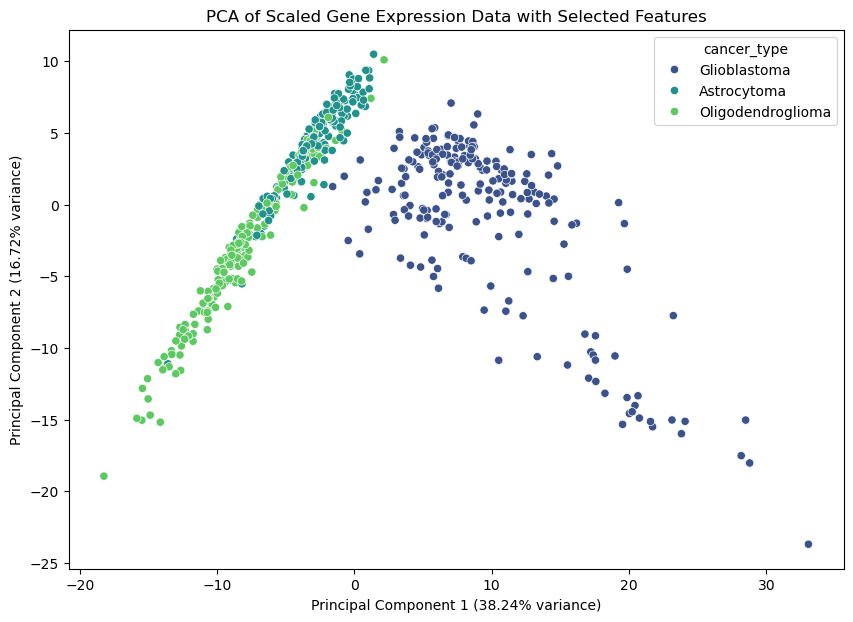

In [52]:
from sklearn.decomposition import PCA
from scipy.stats import kruskal
import umap
from sklearn.manifold import TSNE


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

explained_variance = pca.explained_variance_ratio_
explained_var_pc1 = explained_variance[0] * 100  
explained_var_pc2 = explained_variance[1] * 100  

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_df['cancer_type'], palette="viridis")

plt.title(f'PCA of Scaled Gene Expression Data with Selected Features')
plt.xlabel(f'Principal Component 1 ({explained_var_pc1:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_var_pc2:.2f}% variance)')

plt.show()

#### UMAP

/home/kbanerj1/.conda/envs/JupyterLab/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


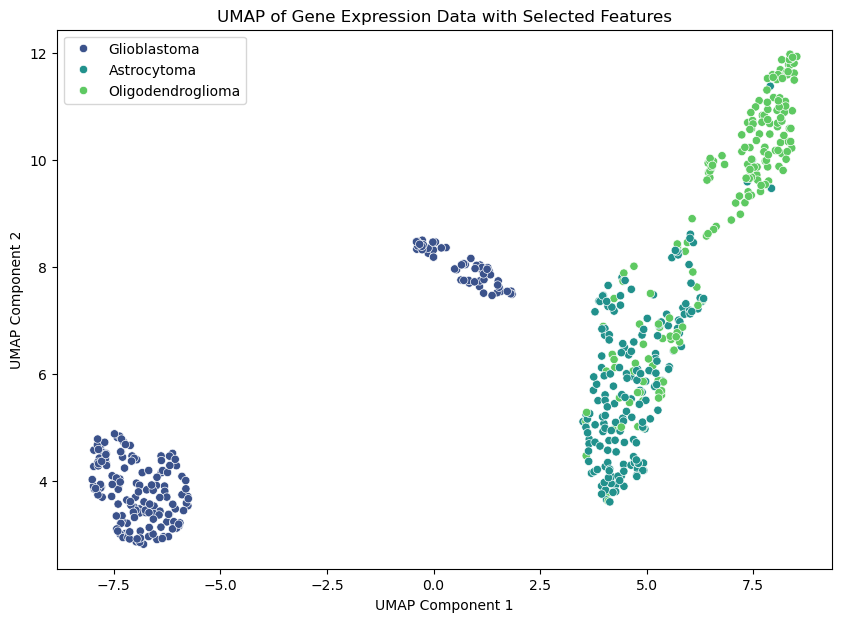

In [53]:
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_selected) 

# Plot the UMAP result
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_df['cancer_type'], palette="viridis")
plt.title('UMAP of Gene Expression Data with Selected Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='best')
plt.show()

## Unsupervised Clustering 

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # n_clusters = 3 for three cancer types
kmeans_labels = kmeans.fit_predict(X_selected)

# Measures similarity between cluster labels and true labels
ari_score = adjusted_rand_score(y, kmeans_labels)

# Print evaluation metrics
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Adjusted Rand Index (ARI): 0.4429


/home/kbanerj1/.conda/envs/JupyterLab/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


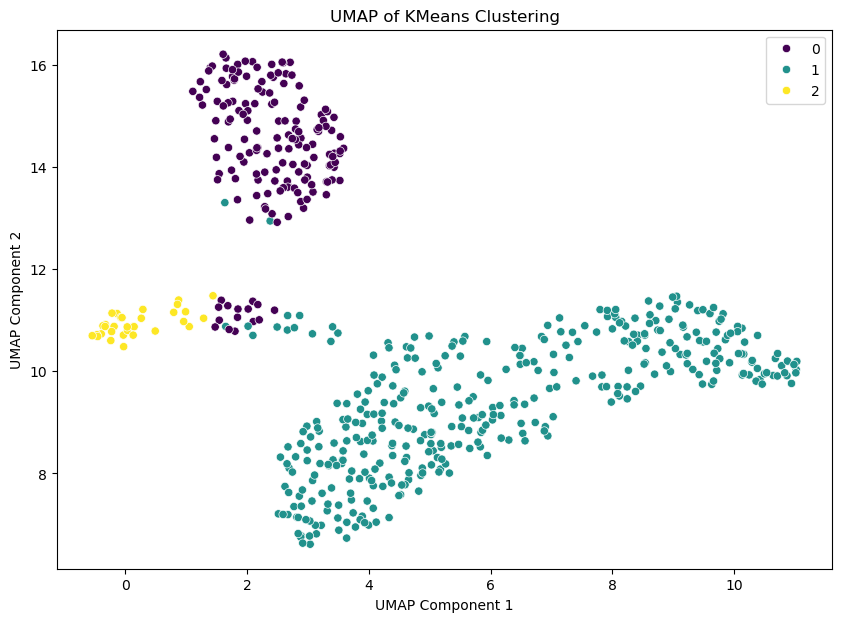

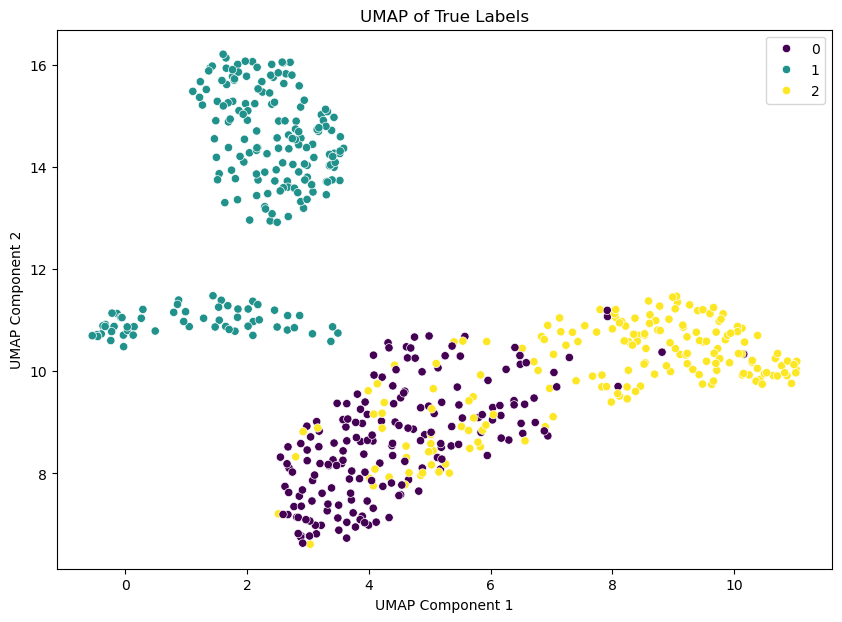

In [74]:
umap_embedding = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42).fit_transform(X_selected)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=kmeans_labels, palette="viridis", legend='full')
plt.title('UMAP of KMeans Clustering')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=y, palette="viridis", legend='full')
plt.title('UMAP of True Labels')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

## Model Training

In [56]:
# split the data 
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# to reduce code bloat for my own sanity
# cross-validation function 
def cross_validate_model(model, X, y, cv_splits=5):
    
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc_ovr')

    print("Cross-Validation Accuracy Scores:", accuracy_scores)
    print("Mean Accuracy:", np.mean(accuracy_scores))
    print("Cross-Validation AUC-ROC Scores:", roc_auc_scores)
    print("Mean AUC-ROC:", np.mean(roc_auc_scores))
    
    return accuracy_scores, roc_auc_scores

# training function
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    print("\nModel Performance on Test Set:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    return y_pred, y_prob

def plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Logistic Regression

Cross-Validation Accuracy Scores: [0.86086957 0.93043478 0.86956522 0.85217391 0.88695652]
Mean Accuracy: 0.8799999999999999
Cross-Validation AUC-ROC Scores: [0.93217219 0.97894097 0.95357602 0.9503062  0.95807346]
Mean AUC-ROC: 0.954613766639083

Model Performance on Test Set:
Accuracy: 0.8695652173913043
Confusion Matrix:
 [[30  0  6]
 [ 0 42  0]
 [ 9  0 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        36
           1       1.00      1.00      1.00        42
           2       0.82      0.76      0.79        37

    accuracy                           0.87       115
   macro avg       0.86      0.86      0.86       115
weighted avg       0.87      0.87      0.87       115



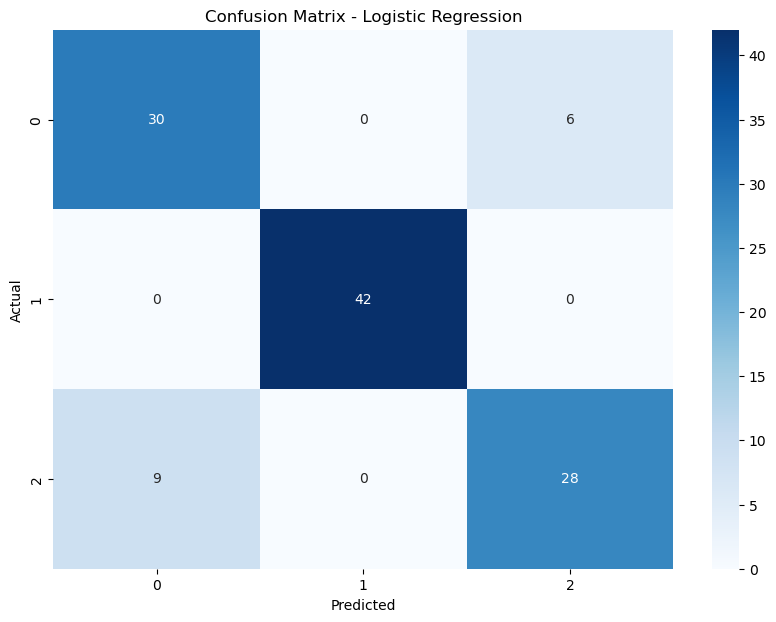

AUC-ROC on Multi-class: 0.9490391072669553


In [58]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=300, random_state=42)
accuracy_scores, roc_auc_scores = cross_validate_model(lr_model, X_selected, y)
y_pred_lr, y_prob_lr = train_evaluate_model(lr_model, X_train, y_train, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_lr, title="Confusion Matrix - Logistic Regression")

# Calculate AUC-ROC for multi-class 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
auc_roc = roc_auc_score(y_test, y_prob_lr, multi_class='ovr')
print("AUC-ROC on Multi-class:", auc_roc)

### Random Forest

Cross-Validation Accuracy Scores: [0.85217391 0.93043478 0.86086957 0.88695652 0.88695652]
Mean Accuracy: 0.8834782608695653
Cross-Validation AUC-ROC Scores: [0.94793418 0.98336153 0.9549128  0.95972567 0.97343497]
Mean AUC-ROC: 0.9638738300130705

Model Performance on Test Set:
Accuracy: 0.9217391304347826
Confusion Matrix:
 [[35  0  1]
 [ 0 42  0]
 [ 8  0 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.89        36
           1       1.00      1.00      1.00        42
           2       0.97      0.78      0.87        37

    accuracy                           0.92       115
   macro avg       0.93      0.92      0.92       115
weighted avg       0.93      0.92      0.92       115



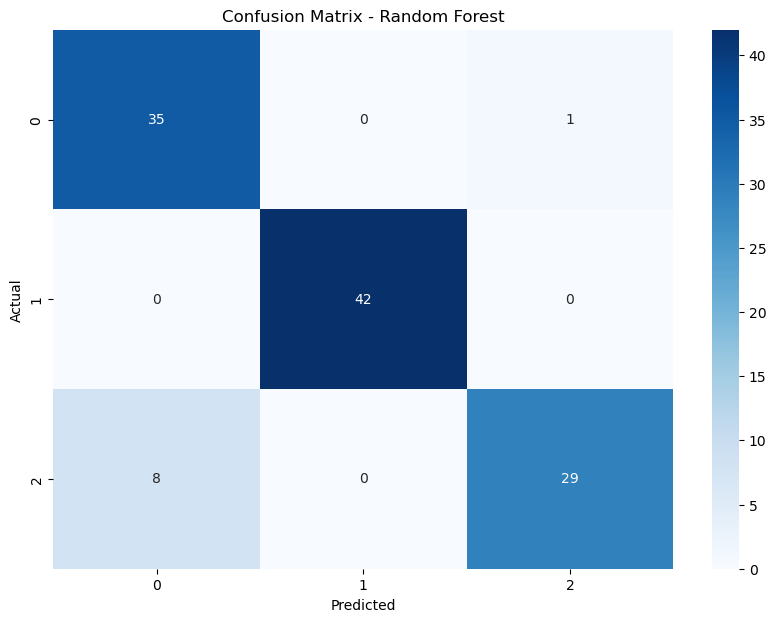

AUC-ROC on mult-class: 0.9703325526110337


In [59]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

accuracy_scores, roc_auc_scores = cross_validate_model(rf_model, X_selected, y)
y_pred_rf, y_prob_rf = train_evaluate_model(rf_model, X_train, y_train, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_rf, title="Confusion Matrix - Random Forest")

# Calculate AUC-ROC for multi-class 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
auc_roc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
print("AUC-ROC on mult-class:", auc_roc_rf)

In [ ]:
#### Feature Importance

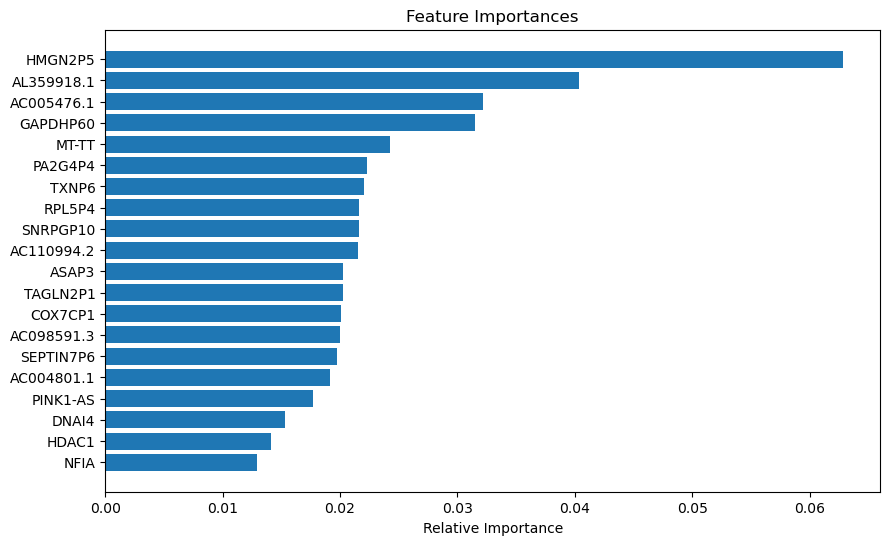

In [80]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X_selected.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###  XGBoost classifier

Cross-Validation Accuracy Scores: [0.86086957 0.93043478 0.86956522 0.87826087 0.92173913]
Mean Accuracy: 0.8921739130434782
Cross-Validation AUC-ROC Scores: [0.9564874  0.97882035 0.95392934 0.95004108 0.97920998]
Mean AUC-ROC: 0.9636976314191503

Model Performance on Test Set:
Accuracy: 0.8869565217391304
Confusion Matrix:
 [[32  0  4]
 [ 0 42  0]
 [ 9  0 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83        36
           1       1.00      1.00      1.00        42
           2       0.88      0.76      0.81        37

    accuracy                           0.89       115
   macro avg       0.89      0.88      0.88       115
weighted avg       0.89      0.89      0.89       115



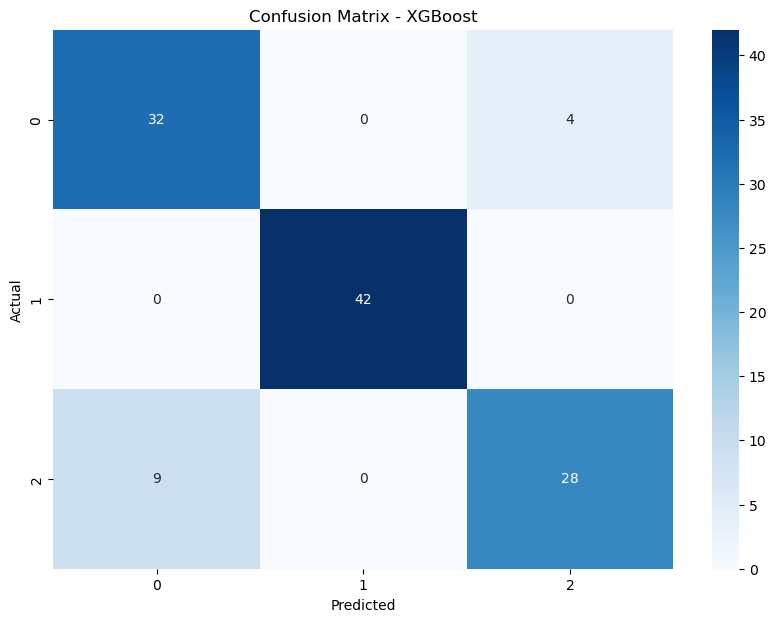

AUC-ROC on mult-class: 0.9753331715357033


In [60]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss', n_estimators=50)

accuracy_scores, roc_auc_scores = cross_validate_model(xgb_model, X_selected, y)
y_pred_xgb, y_prob_xgb = train_evaluate_model(xgb_model, X_train, y_train, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_xgb, title="Confusion Matrix - XGBoost")

# Calculate AUC-ROC for multi-class 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
auc_roc_xgb = roc_auc_score(y_test, y_prob_xgb, multi_class='ovr')
print("AUC-ROC on mult-class:", auc_roc_xgb)

Overall, all models have similar performance, with XGBoost with slightly better performance. Although, all models struggle with the "Oligodendroglioma". vs  "Astrocytoma"  comparison. 

#### Feature Importance

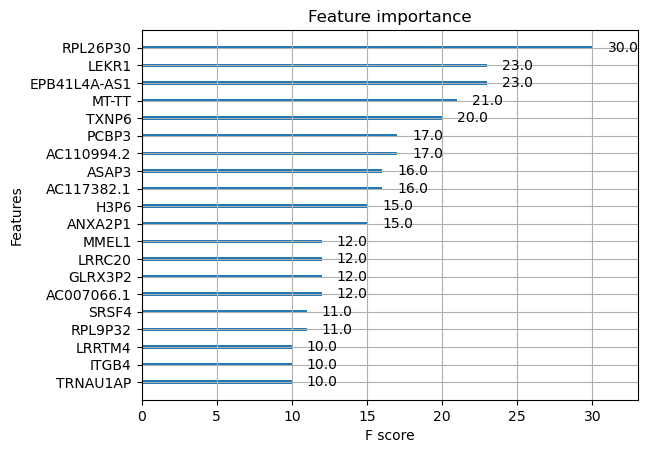

In [78]:
# https://stackoverflow.com/questions/51905524/plot-feature-importance-with-xgboost 
xgb.plot_importance(xgb_model,max_num_features = 20)
plt.show()

## Saving Model

In [83]:
import joblib

models_dir = './models'
os.makedirs(models_dir, exist_ok=True)
model_file_path = os.path.join(models_dir, 'xgb_model.pkl')
# Save the trained  model
joblib.dump(xgb_model, model_file_path)
# Save scaler
scaler_file_path = './models/scaler.pkl'
joblib.dump(scaler, scaler_file_path)

['./models/scaler.pkl']